# **Speech Emotion Recogition (Classification) in real-time using Deep LSTM layers**
### ***A Deep Learning LSTM based model with keras.***
---
Speech Emotion Recognition Final project Deep learning Course
submmit Students:
Noam Efrat

Daniel Nachshoni

Tomer Ramon 

Based on the work of  
**Meidan Greenberg & Linoy Hadad.**

Instructor: **Dr. Dima Alberg**

Industial Engineering and Management dept.

SCE Collage, Israel.







# **ABSTRACT**
This study aims to investigate and implement an Artificial Intelligence (AI) model that will analyze a speech audio input in real-time, identify and present the expressed emotion within it. 

This classification model is developed in a Deep Learning method, meaning a Deep Neural Network (DNN) while an advanced model for time-series analysis has been chosen, which is the Long Short-Term Memory (LSTM). 

For the train of the model, expressed emotions by actors have been used from The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS) from the Ryerson University, as well as the Toronto Emotional Speech Set (TESS) from the University of Toronto.

Results had shown an accuracy of 87.23% of emotional recognition from speech.

This notebook contains the first part of the study, ahead of a real-time system for speech emotion recognition system (SER).


---



# **LIBRARIES & GOOGLE AUTH**

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
%%capture
!pip install pydub
!pip install noisereduce
!pip install json-tricks

In [ ]:
%%capture
import numpy as np
import os
from json_tricks import dump, load
from pydub import AudioSegment, effects
import librosa
import noisereduce as nr
import tensorflow as tf
import keras
import sklearn
import wave as wa
import webbrowser
from io import BytesIO
import matplotlib.pyplot as plt 
from PIL import Image
from google.colab import files

# **THE DATA**
The speech emotion audio databases used:

- **The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS)**
https://zenodo.org/record/1188976#.X4sE0tDXKUl
  - The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS) was recorded with 24 professional actors (12 female, 12 male), vocalizing two lexically-matched statements in a neutral North American accent. Each expression is produced at two levels of emotional intensity (normal, strong), with an additional neutral expression. 
  - **1440 files** = 24 actors x 60 trails per actor
  - **8 Emotions** (neutral, calm, happy, sad, angry, fearful, disgust, surprised).


**7 Files self recorded audio files has been added as 'Actor_25_Daniel' for our new emotion - frustration. **

## **Features extraction**
The selected features being extracted with `librosa` for the speech emotion recognition model are:

1.   Energy - Root Mean Square (RMS)
2.   Zero Crossed Rate (ZCR)
3.   Mel-Frequency Cepstral Coefficients (MFCCs) 

With `frame_length = 2048`, `hop_lentgh = 512`, assuring equally sequential length. 

**Explanation:**

Every 2048 samples (sequence of ~0.058 seconds on average) are being analyzed and translated to 4 sequential feature values (2048 / 512 = 4). 

In total, for an audio file lengthed 173056 samples, considering the last sample, 339 sequential values are returned for each feature  (173056+1 / 512 = 339).

Audio preprocess and feature extraction is presented for a single audio file in "1_preprocess_for_one_audiofile" notebook.

## **Emotion representation**
There is a different representation of the emotions in each database.

#### **RAVDESS Database**

*   A RAVDESS filename consists of a 7-part numerical identifier (e.g., 03-01-06-01-02-01-12.wav). The format which carries only emotion expressed by speech is taken as 03-01-X-X-X-X-X.wav, as the 8 emotions are stated in the 3rd part (The 1st 'X' within the file-name format).

 
#### **TESS Database**

*   A TESS file name contains the emotion by a direct text, e.g. "YAF_youth_happy.wav". 

*    To overcome this incompatibility with the RAVDESS representation, "find_emotion" function has been executed.


In addition, classification modeling accepting only values starting from zero, thus "emotionfix" function has been executed for all files, performing an 'n = n-1' process for the emotion representation.


In [ ]:
# Emotion kind validation function for TESS database, due to emotions written within the file names.
def find_emotion_T(name): 
        if('neutral' in name): return "01"
        elif('happy' in name): return "03"
        elif('sad' in name): return "04"
        elif('angry' in name): return "05"
        elif('fear' in name): return "06"
        elif('disgust' in name): return "07"
        elif('ps' in name): return "08"
        elif('frustrated' in name): return "09"
        else: return "-1"
        
        
# 'emotions' list fix for classification purposes:
#     Classification values start from 0, Thus an 'n = n-1' operation has been executed for both RAVDESS and TESS databases:
def emotionfix(e_num):
    if e_num == "01":   return 0 # neutral
    elif e_num == "02": return 1 # calm
    elif e_num == "03": return 2 # happy
    elif e_num == "04": return 3 # sad
    elif e_num == "05": return 4 # angry
    elif e_num == "06": return 5 # fear
    elif e_num == "07": return 6 # disgust
    elif e_num == "08": return 7 # suprised
    else:               return 8 # new emotion - frustrated
    

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600


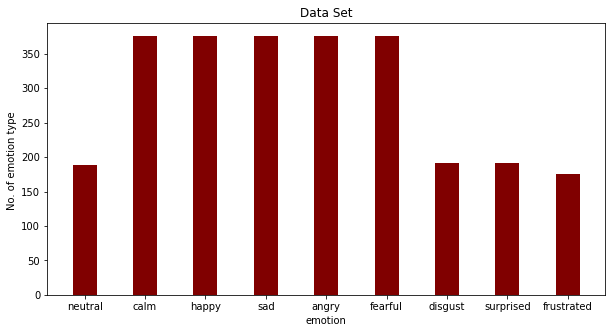

In [ ]:
# Maximum samples count for padding purposes.
from matplotlib import pyplot as plt

sample_lengths = []
loopCounter=0
emotions_arr= np.zeros(9)
folder_path= '/content/drive/MyDrive/DeepLearningDataSet/ExtractedDataSet'

# load files, any file containing audio below 30dB would be considered silent and will be trimmed.
for subdir, dirs, files in os.walk(folder_path):
  for file in files: 
    if (loopCounter%100==0): # number of files has been so far accessing for indication for remaining files.
      print(loopCounter)
                              #RAVDESS database validation
    name = file[6:8]
    emotions_arr[emotionfix(name)]+=1   
    loopCounter+=1
    x, sr = librosa.load(path = os.path.join(subdir,file), sr = None)
    xt, index = librosa.effects.trim(x, top_db=30)
    
    sample_lengths.append(len(xt))

# plot information regarding amount appearances of each emotion.
fig = plt.figure(figsize = (10, 5))
em=['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised', 'frustrated']
# creating the bar plot
plt.bar(em,emotions_arr, color ='maroon', width=0.4)

plt.xlabel("emotion")
plt.ylabel("No. of emotion type ")
plt.title("Data Set")
plt.show()

In [ ]:
print(emotions_arr.sum())

2627.0


## **THE PREPROCESS**
Following the preprocessing presentation for a single audio file in "1_preprocess_for_one_audiofile" notebook, the full data will be preprocessed and extracted as the speech features chosen.

In [ ]:
import time
tic = time.perf_counter()

# Initialize data lists
rms = [] # root mean square
zcr = [] # zero crossing rate
mfcc = [] # Mel-frequency cepstrum
emotions = []

# Initialize variables

total_length = 340000 # largest length of samples, will be used for padding.
frame_length = 2048
hop_length = 512

loopCounter=0
folder_path = '/content/drive/MyDrive/DeepLearningDataSet/ExtractedDataSet' 
index_i=0

for subdir, dirs, files in os.walk(folder_path):
  for file in files: 
      loopCounter+=1
      if (loopCounter%100==0):
        print(loopCounter)
  
    # Fetch the sample rate.
      _, sr = librosa.load(path = os.path.join(subdir,file), sr = None) # sr (the sample rate) is used for librosa's MFCCs. '_' is irrelevant.
    # Load the audio file.
      rawsound = AudioSegment.from_file(os.path.join(subdir,file)) 
    # Normalize the audio to +5.0 dBFS.
      normalizedsound = effects.normalize(rawsound, headroom = 0) 
    # Transform the normalized audio to np.array of samples.
      normal_x = np.array(normalizedsound.get_array_of_samples(), dtype = 'float32')
    # Trim silence from the beginning and the end.
      xt, index = librosa.effects.trim(normal_x, top_db=30)
      # print(file,"\t", len(xt), "\t", rawsound.dBFS, "\t", normalizedsound.dBFS) #--QA purposes if needed-- 
    # Pad for duration equalization.
      padded_x = np.pad(xt, (0, total_length-len(xt)), 'constant') 
    # Noise reduction.
      final_x = nr.reduce_noise(padded_x, sr=sr) # updated 03/03/22
       
   # Features extraction 
      f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square   
      f2 = librosa.feature.zero_crossing_rate(final_x , frame_length=frame_length, hop_length=hop_length, center=True) # ZCR      
      f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
      

   # Emotion extraction from the different databases
      if (find_emotion_T(file) != "-1"): #TESS database validation
            name = find_emotion_T(file)
      else:                              #RAVDESS database validation
            name = file[6:8]                      

   # Filling the data lists  
      rms.append(f1)
      zcr.append(f2)
      mfcc.append(f3)
      emotions.append(emotionfix(name)) 

toc = time.perf_counter()
print(f"Running time: {(toc - tic)/60:0.4f} minutes")

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
Running time: 9.8671 minutes


# **FINAL DATA SETUP**
In order to input the data into a model, a few adjustments should be made:


*   The shapes of the features must be uniform, and in the 3D format: 

 **(batch, timesteps, feature)**
*   Concatenating all features to a single 'X' variable.
*   Adjustment of 'Y' with a 2D shape (keras library requirement)
*   Split of X, Y to train, validation, and test sets.
*   y_train and y_validation conversion to 'One-hot' vectors for classification purposes (y_test is being converted adjacent to the test)




**X, Y Setup**

In [ ]:
# Adjusting features shape to the 3D format: (batch, timesteps, feature)

f_rms = np.asarray(rms).astype('float32')
f_rms = np.swapaxes(f_rms,1,2)
f_zcr = np.asarray(zcr).astype('float32')
f_zcr = np.swapaxes(f_zcr,1,2)
f_mfccs = np.asarray(mfcc).astype('float32')
f_mfccs = np.swapaxes(f_mfccs,1,2)

print('ZCR shape:',f_zcr.shape)
print('RMS shape:',f_rms.shape)
print('MFCCs shape:',f_mfccs.shape)



ZCR shape: (2627, 665, 1)
RMS shape: (2627, 665, 1)
MFCCs shape: (2627, 665, 13)


**Note: a total of 8 files had been removed from both databases due to various file corruptions.**

In [ ]:
# Concatenating all features to 'X' variable.
X = np.concatenate((f_zcr, f_rms, f_mfccs), axis=2)

# Preparing 'Y' as a 2D shaped variable.
Y = np.asarray(emotions).astype('int8')
Y = np.expand_dims(Y, axis=1)

**Save & Load X,Y to JSON files**

In [ ]:
# Save X,Y arrays as lists to json files.

x_data = X.tolist() 
x_path = '/content/drive/My Drive/Colab Notebooks/X_datanew.json' # FILE SAVE PATH
dump(obj = x_data, fp = x_path)

y_data = Y.tolist() 
y_path = '/content/drive/My Drive/Colab Notebooks/Y_datanew.json' # FILE SAVE PATH
dump(obj = y_data, fp = y_path)


'[[0], [0], [0], [0], [1], [1], [1], [1], [1], [1], [2], [1], [1], [2], [2], [2], [2], [3], [2], [2], [3], [3], [2], [3], [4], [4], [3], [4], [4], [3], [4], [4], [4], [3], [3], [4], [5], [5], [5], [5], [5], [5], [5], [5], [0], [0], [0], [0], [1], [1], [1], [2], [1], [1], [1], [1], [1], [2], [2], [2], [2], [2], [2], [3], [3], [3], [3], [2], [4], [4], [3], [3], [4], [4], [4], [4], [3], [3], [5], [5], [4], [5], [5], [4], [5], [5], [5], [5], [0], [0], [0], [1], [0], [1], [1], [2], [2], [1], [2], [1], [1], [1], [2], [1], [3], [3], [2], [2], [3], [3], [3], [2], [2], [3], [3], [4], [4], [4], [4], [4], [4], [4], [5], [4], [5], [3], [5], [5], [5], [5], [5], [5], [1], [0], [0], [1], [1], [0], [0], [2], [2], [1], [2], [1], [1], [2], [1], [1], [2], [2], [3], [2], [3], [3], [3], [3], [3], [3], [3], [2], [5], [4], [4], [4], [4], [4], [4], [5], [4], [5], [4], [5], [5], [5], [5], [5], [0], [1], [1], [1], [1], [1], [0], [0], [1], [0], [1], [1], [2], [2], [3], [2], [2], [2], [2], [2], [3], [2], [3], [3]

In [ ]:
# Load X,Y json files back into lists, convert to np.arrays

x_path = '/content/drive/My Drive/Colab Notebooks/X_datanew.json' # FILE LOAD PATH
X = load(x_path)
X = np.asarray(X, dtype = 'float32')
y_path = '/content/drive/My Drive/Colab Notebooks/Y_datanew.json' # FILE LOAD PATH
Y = load(y_path)
Y = np.asarray(Y, dtype = 'int8')


*   **Split X, Y To Train, Validation, and Test Sets**
*   **y_train and y_val conversion to One-Hot vectors.**



In [ ]:
# Split to train, validation, and test sets.
from sklearn.model_selection import train_test_split
x_train, x_tosplit, y_train, y_tosplit = train_test_split(X, Y, test_size = 0.125, random_state = 1)
x_val, x_test, y_val, y_test = train_test_split(x_tosplit, y_tosplit, test_size = 0.304, random_state = 1)
#'One-hot' vectors for Y: emotion classification
y_train_class = tf.keras.utils.to_categorical(y_train, 9, dtype = 'int8') 
# print(y_train_class)
y_val_class = tf.keras.utils.to_categorical(y_val, 9, dtype = 'int8')
print(y_val_class.shape)

(228, 9)


In [ ]:
# Save x_test, y_test to JSON.

file_path = 'x_test_data.json'
dump(obj = x_test, fp = file_path)

file_path = 'y_test_data.json'
dump(obj = y_test, fp = file_path)

'{"__ndarray__": [[3], [0], [6], [8], [5], [5], [2], [6], [4], [3], [1], [4], [3], [1], [4], [3], [8], [7], [1], [6], [4], [5], [4], [4], [8], [0], [8], [7], [5], [4], [3], [8], [7], [2], [7], [4], [5], [4], [0], [4], [3], [0], [6], [0], [0], [5], [5], [2], [4], [5], [4], [7], [0], [3], [4], [3], [3], [0], [5], [1], [7], [8], [4], [7], [3], [1], [3], [1], [0], [4], [2], [1], [0], [6], [5], [7], [2], [7], [3], [5], [1], [5], [0], [6], [4], [2], [2], [1], [1], [5], [1], [6], [2], [5], [5], [5], [5], [6], [4], [7], [0]], "dtype": "int8", "shape": [101, 1], "Corder": true}'

# **MODEL DEFINITION & TRAIN**


In [ ]:
from keras.models import Sequential
from keras import layers
from keras import optimizers
from keras import callbacks 

In [ ]:
# Initializing the model

# our model functions under the basis of Sequential Data.
# Sequential data - when one piece of information depends upon the one before him or after him.
# notice that our information is based on a certain sequence, such that our audio file can continiously change. 
# plus, we have a relationship of many-to-one, as if, multiple inputs, singular output.



model = Sequential()
# adding LSTM layer means a layer with a memory, which is needed for sequential data.

model.add(layers.LSTM(64, return_sequences = True, input_shape=(X.shape[1:3])))
model.add(layers.LSTM(64))
# softmax mean changing from a vector of numbers of vector of probabilities.
# we choose the vector to be in the same size as of our emotions list.

model.add(layers.Dense(9, activation = 'softmax'))
print(model.summary())

batch_size = 23

# Callbacks functions
checkpoint_path = '/content/drive/My Drive/Colab Notebooks/best_weights.hdf5'

#-> Save the best weights
mcp_save = callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True,
                           monitor='val_categorical_accuracy',
                           mode='max')
#-> Reduce learning rate after 100 epoches without improvement.
rlrop = callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', 
                                    factor=0.1, patience=100)
                             
# Compile & train   
model.compile(loss='categorical_crossentropy', 
                optimizer='RMSProp', 
                metrics=['categorical_accuracy'])

# trainning.
history = model.fit(x_train, y_train_class, 
                      epochs=225, batch_size = batch_size, #change epochs
                      validation_data = (x_val, y_val_class), 
                      callbacks = [mcp_save, rlrop])
# Define the best weights to the model.
model.load_weights(checkpoint_path)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 665, 64)           20480     
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_1 (Dense)             (None, 9)                 585       
                                                                 
Total params: 54,089
Trainable params: 54,089
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/225
100/100 [==============================] - 8s 51ms/step - loss: 2.0889 - categorical_accuracy: 0.1680 - val_loss: 1.9319 - val_categorical_accuracy: 0.1754 - lr: 0.0010
Epoch 2/225
100/100 [==============================] - 4s 42ms/step - loss: 1.9810 - categorical_accuracy: 0.2106 - val_loss: 1.

# **MODEL EVALUATION**
The model has been evaluated using the following factors:


1.   A visualization of the loss and categorial accuracy values trend during the train process.
2.   A confusion matrix for visualizing the number of successful predictions of each emotion: for validation and test sets.
3.   Model's prediction accuracy rates for each emotion: for validation and test sets.


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt 

## **Train (fit) Visualization**

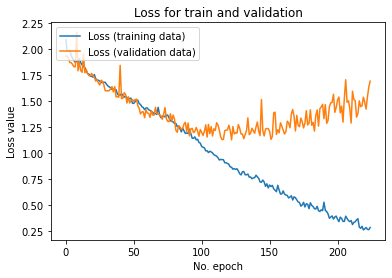

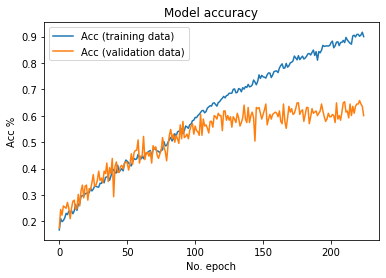

In [ ]:
# Loss, Accuracy presentation

# Plot history: Loss
plt.plot(history.history['loss'], label='Loss (training data)')
plt.plot(history.history['val_loss'], label='Loss (validation data)')
plt.title('Loss for train and validation')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

#Plot history: Accuracy
plt.plot(history.history['categorical_accuracy'], label='Acc (training data)')
plt.plot(history.history['val_categorical_accuracy'], label='Acc (validation data)')
plt.title('Model accuracy')
plt.ylabel('Acc %')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

## **Validation Set Evaluation**

**Val Set Score**

In [ ]:
# Validation score
loss,acc = model.evaluate(x_val, y_val_class, verbose=2)

8/8 - 0s - loss: 1.4225 - categorical_accuracy: 0.6579 - 171ms/epoch - 21ms/step


**Val Set Confussion Matrix**

cm
 (9, 9)


Text(0.5, 60.0, 'Predicted emotion')

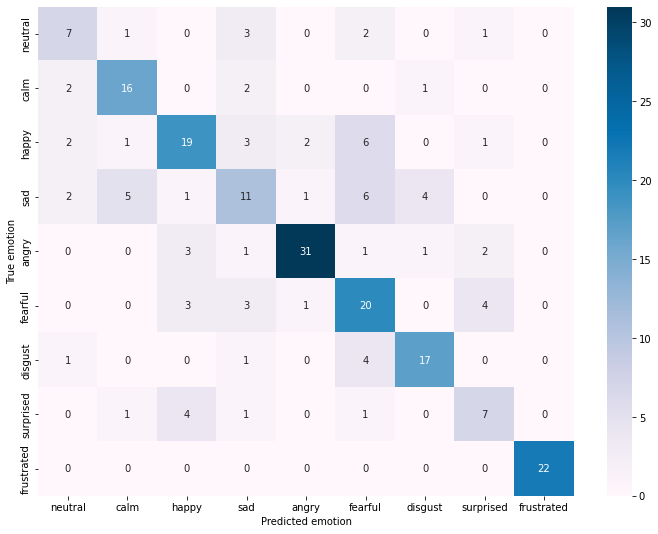

In [ ]:
# Validation Confusion matrix
import pandas as pd
new_y_val_class = np.argmax(y_val_class, axis=1)
predictions = model.predict(x_val)
new_y_pred_class = np.argmax(predictions, axis=1)


cm=confusion_matrix(new_y_val_class, new_y_pred_class) 
print("cm\n",cm.shape)

index = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised', 'frustrated']
columns = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised', 'frustrated']
 

cm_df = pd.DataFrame(cm, index, columns)
plt.figure(figsize=(12,9))
ax = plt.axes()

sns.heatmap(cm_df, ax = ax, cmap = 'PuBu', fmt="d", annot=True)
ax.set_ylabel('True emotion')
ax.set_xlabel('Predicted emotion')

**Validation Set Predicted emotions accuracy**

In [ ]:
# Validation set prediction accuracy rates

values = cm.diagonal()
row_sum = np.sum(cm,axis=1)
acc = values / row_sum
fig = plt.figure(figsize = (10, 5))
em=['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised', 'frustrated']
# creating the bar plot
# plt.bar(em,index, color =['black', 'red', 'green', 'blue', 'cyan','black', 'red', 'green', 'blue', 'cyan','yellow'], width=0.4)

# plt.xlabel("emotion")
# plt.ylabel("No. of emotion type ")
# plt.title("emotions accuracy")
# plt.show()
print('Validation set predicted emotions accuracy:')
for e in range(0, len(values)):
    print(index[e],':', f"{(acc[e]):0.4f}")

Validation set predicted emotions accuracy:
neutral : 0.5000
calm : 0.7619
happy : 0.5588
sad : 0.3667
angry : 0.7949
fearful : 0.6452
disgust : 0.7391
surprised : 0.5000
frustrated : 1.0000


<Figure size 720x360 with 0 Axes>

## **Save & Load model, weights**


In [ ]:
# Saving model & weights

from keras.models import model_from_json
from keras.models import load_model

model_json = model.to_json()
saved_model_path = '/content/drive/My Drive/Colab Notebooks/model8723.json'
saved_weights_path = '/content/drive/My Drive/Colab Notebooks/model8723_weights.h5'


with open(saved_model_path, "w") as json_file:
    json_file.write(model_json)
    
model.save_weights(saved_weights_path)
print("Saved model to disk")


Saved model to disk


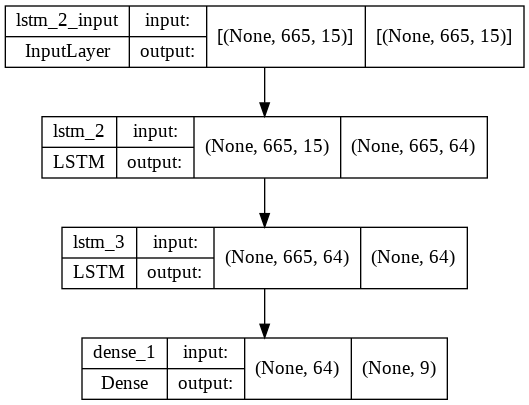

In [ ]:
# Reading the model from JSON file

saved_model_path = '/content/drive/My Drive/Colab Notebooks/model8723.json'
saved_weights_path = '/content/drive/My Drive/Colab Notebooks/model8723_weights.h5'

with open(saved_model_path , 'r') as json_file:
    json_savedModel = json_file.read()
    
# Loading the model architecture, weights
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights(saved_weights_path)

# Compiling the model with similar parameters as the original model.
model.compile(loss='categorical_crossentropy', 
                optimizer='RMSProp', 
                metrics=['categorical_accuracy'])

# Model's structure visualization
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Loading x_test, y_test json files, and converting to np.arrays

x_test = load( 'x_test_data.json')
x_test = np.asarray(x_test).astype('float32')

y_test = load('y_test_data.json')
y_test = np.asarray(y_test).astype('int8')

y_test_class = tf.keras.utils.to_categorical(y_test, 9, dtype = 'int8')

## **Test Set Evaluation**

**Test Set Score**

In [ ]:
loss, acc = model.evaluate(x_test, y_test_class, verbose=2)

4/4 - 1s - loss: 1.5865 - categorical_accuracy: 0.6040 - 1s/epoch - 359ms/step


**Test Set Confussion Matrix**

Text(0.5, 60.0, 'Predicted emotion')

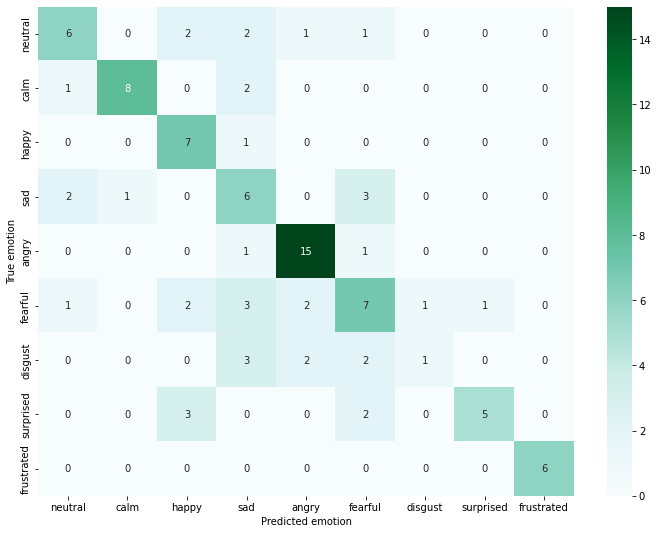

In [ ]:
# Test set Confusion matrix

y_test_class = np.argmax(y_test_class, axis=1)
predictions = model.predict(x_test)
y_pred_class = np.argmax(predictions, axis=1)

cm=confusion_matrix(y_test_class, y_pred_class)

index = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised', 'frustrated']  
columns = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised', 'frustrated']  

cm_df = pd.DataFrame(cm,index,columns)                      
plt.figure(figsize=(12,9))
ax = plt.axes()

sns.heatmap(cm_df, ax = ax, cmap = 'BuGn', fmt="d", annot=True)
ax.set_ylabel('True emotion')
ax.set_xlabel('Predicted emotion')

**Test Set Predicted emotions accuracy**

In [ ]:
# Test set prediction accuracy rates

values = cm.diagonal()
row_sum = np.sum(cm,axis=1)
acc = values / row_sum

print('Test set predicted emotions accuracy:')


for e in range(0, len(values)):
    print(index[e],':', f"{(acc[e]):0.4f}")

Test set predicted emotions accuracy:
neutral : 0.5000
calm : 0.7273
happy : 0.8750
sad : 0.5000
angry : 0.8824
fearful : 0.4118
disgust : 0.1250
surprised : 0.5000
frustrated : 1.0000


`From here - added feature for allowing user to insert audio file and test classification of emotion`

Saving UML.jpeg to UML.jpeg


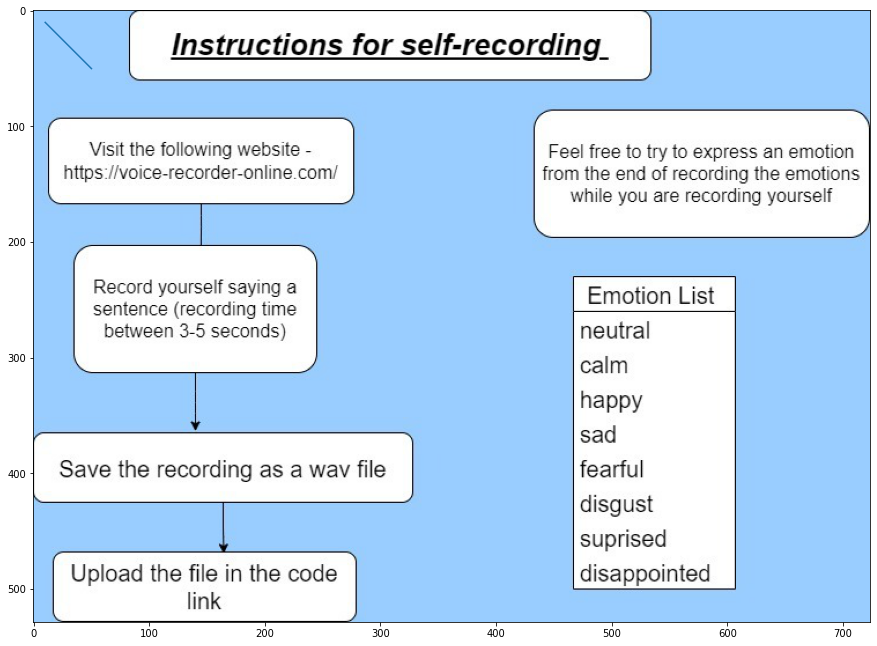

In [ ]:
from google.colab import files
upl = files.upload()
filename = next(iter(upl))
im = Image.open(BytesIO(upl[filename])) # add to drive
plt.figure(figsize=(15,15))
x = [10,10,50]
plt.plot(x, x)
plt.imshow(im)  
plt.show()   

In [ ]:
print( " please enter to this web site  *** https://voice-recorder-online.com  ** and follow the instruction ")

In [ ]:
# IN ORDER FOR THIS TO WORK - BROWSER REQUIRES TURN OFF THE BLOCKING OF COOKIES.
uploaded = files.upload()

# validation for the file. 
for fn in uploaded.keys():
  na=fn
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

file2 = wa.open(na, "r")
print(file2.getcompname())
frames = file2.getnframes()
rate = file2.getframerate()
duration = frames / float(rate)
if duration < 3 or duration > 6:
    print("File shorter than 3 seconds or longer than 6 Please re-record according to instructions\n")

print("The length of the file is", duration)




Saving 03-02-01-01-01-02-07.wav to 03-02-01-01-01-02-07.wav
User uploaded file "03-02-01-01-01-02-07.wav" with length 442400 bytes
not compressed
The length of the file is 4.2709375


In [ ]:
rms = []
zcr = []
mfcc = []
emotions = []

# Initialize variables

#THE ORIGINAL

total_length = 340000 # desired frame length for all of the audio samples.

frame_length = 2048
hop_length = 512
tic = time.time()

# Fetch the sample rate.
_, sr = librosa.load(na, sr = None) # sr (the sample rate) is used for librosa's MFCCs. '_' is irrelevant.
# Load the audio file.
rawsound = AudioSegment.from_file(na) 
# Normalize the audio to +5.0 dBFS.
normalizedsound = effects.normalize(rawsound, headroom = 0) 
# Transform the normalized audio to np.array of samples.
normal_x = np.array(normalizedsound.get_array_of_samples(), dtype = 'float32')
# Trim silence from the beginning and the end.
xt, index = librosa.effects.trim(normal_x, top_db=30)
print(na,"\t", len(xt), "\t", rawsound.dBFS, "\t", normalizedsound.dBFS) #--QA purposes if needed-- 
# Pad for duration equalization.
padded_x = np.pad(xt, (0, total_length-len(xt)), 'constant') 

final_x = nr.reduce_noise(padded_x, sr=sr)

f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square   
f2 = librosa.feature.zero_crossing_rate(final_x , frame_length=frame_length, hop_length=hop_length, center=True) # ZCR      
f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC

rms.append(f1)
zcr.append(f2)
mfcc.append(f3)

f_rms = np.asarray(rms).astype('float32')
f_rms = np.swapaxes(f_rms,1,2)
f_zcr = np.asarray(zcr).astype('float32')
f_zcr = np.swapaxes(f_zcr,1,2)
f_mfccs = np.asarray(mfcc).astype('float32')
f_mfccs = np.swapaxes(f_mfccs,1,2)

print('ZCR shape:',f_zcr.shape)
print('RMS shape:',f_rms.shape)
print('MFCCs shape:',f_mfccs.shape)

# Concatenating all features to 'X' variable.
X = np.concatenate((f_zcr, f_rms, f_mfccs), axis=2)
print(X)

# Preparing 'Y' as a 2D shaped variable.
Y = np.asarray(emotions).astype('int8')
Y = np.expand_dims(Y, axis=1)

print( "Sound processing has been completed ")

03-02-01-01-01-02-07.wav 	 114688 	 -42.96188027867397 	 -17.169795044337373
ZCR shape: (1, 665, 1)
RMS shape: (1, 665, 1)
MFCCs shape: (1, 665, 13)
[[[ 1.34765625e-01  1.25555824e+02  5.07490143e+02 ...  1.20806446e+01
   -1.39937534e+01  1.42000027e+01]
  [ 1.93359375e-01  1.22892906e+02  5.10783997e+02 ...  1.31021595e+01
   -1.50105133e+01  1.36087990e+01]
  [ 2.50488281e-01  1.16537552e+02  5.02793579e+02 ...  1.52626495e+01
   -1.79472542e+01  1.08880482e+01]
  ...
  [ 0.00000000e+00  0.00000000e+00  4.35104584e+02 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  4.35104584e+02 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  4.35104584e+02 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]]]
Sound processing has been completed 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  if sys.path[0] == '':


[[7.6886088e-01 1.8268751e-02 1.2563079e-03 2.0124082e-01 5.2007967e-06
  1.0237565e-02 1.2072206e-04 9.8085948e-06 2.0595949e-09]]
please write the emotion that you recorded from this list = neutral, calm, happy, sad, angry, fearful, disgust, surprised, frustrated
neutral
0
[[7.6886088e-01 1.8268751e-02 1.2563079e-03 2.0124082e-01 5.2007967e-06
  1.0237565e-02 1.2072206e-04 9.8085948e-06 2.0595949e-09]]
Model accuracy for your recording=  76.88608765602112


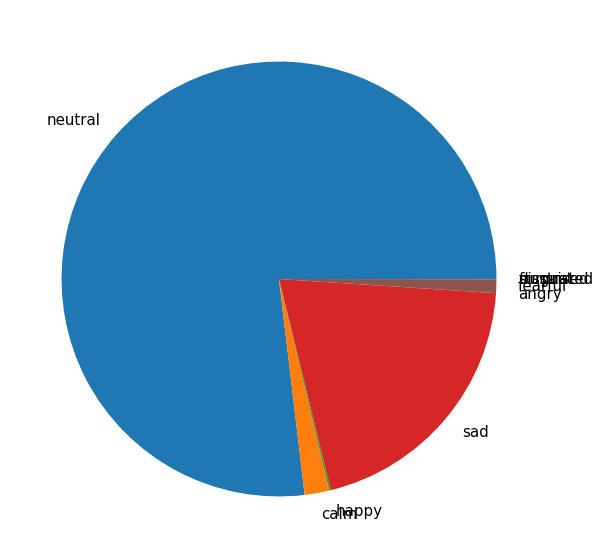

In [ ]:

a=model.predict(X)

print(a)

# Creating dataset
columns = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised', 'frustrated'] 
 
plt.rcParams.update({'font.size': 15})

# Creating plot for representing what is the probability for each emotion of the uploaded file.
fig = plt.figure(figsize =(10, 10))
plt.pie(a, labels = columns)

print("please write the emotion that you recorded from this list = neutral, calm, happy, sad, angry, fearful, disgust, surprised, frustrated")


wts= input()
if wts not in columns:
  print( "worng sensation try again ")
else:
  ind=columns.index(wts)
  print(ind)
  print(a)
  # Model accuracy for your recording
  acc = (a[0,ind])*100
  print("Model accuracy for your recording= ",acc)

# show plot
plt.show()



# **RESULTS & CONCLUSIONS**
As seen, the validation set accuracy of the model had come up to 87.23% and the test set accuracy had reached 84.47% with overfitting in the training process starting around the 100th epoch. Although various regulations have been placed in earlier tryouts, they had restricted the accuracy from reaching its maximum value. A ModelCheckpoint is applied, saving the best weights according to the model's accuracy, thus the overfitting is bypassed. 

Within the next part of the study in which the model will be used as a Real-time SER, The inputs will be processed similarly as the data used by the model, to gain similarity and therefore, precision. 